In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def softmax(x, temp):
    x_adj = x - np.max(x)
    exps = np.exp(x_adj / temp)
    return exps / np.sum(exps)

## Sarsa

In [ ]:
class Sarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env  # Environment
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.temp = temp  # Temperature for softmax exploration
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))  # Q-values initialization

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])  # Select the action with the highest Q-value
        else:
            action_probs = softmax(self.Q[s], self.temp)
            return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        target = r + self.gamma * self.Q[s_prime, a_prime] * (not done)  # TD target
        td_error = target - self.Q[s, a]  # Temporal Difference error
        self.Q[s, a] += self.alpha * td_error  # Update Q-value

## Expected Sarsa

In [ ]:
class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])
        else:
            action_probs = softmax(self.Q[s], self.temp)
            return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

    def update(self, s, a, r, s_prime, done):
        action_probs = softmax(self.Q[s_prime], self.temp)
        expected_q = np.sum(action_probs * self.Q[s_prime])  # Expected value of next state
        target = r + self.gamma * expected_q * (not done)
        td_error = target - self.Q[s, a]
        self.Q[s, a] += self.alpha * td_error

## Hybrid Sarsa Q

In [ ]:
class Hybrid_Sarsa_Q:
    def __init__(self, env, alpha, gamma, temp, beta):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp  # Temperature for softmax
        self.beta = beta  # Mixing factor
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-table

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])  # Choose the best action for evaluation
        else:
            action_probs = softmax(self.Q[s], self.temp)  # Use softmax for exploration
            return np.random.choice(np.arange(self.env.action_space.n), p=action_probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        # Calculate the target with a mixture of max Q and expected Q
        max_q_prime = np.max(self.Q[s_prime])
        action_probs_prime = softmax(self.Q[s_prime], self.temp)
        expected_q_prime = np.sum(action_probs_prime * self.Q[s_prime])
        target = r + self.gamma * ((1 - self.beta) * max_q_prime + self.beta * expected_q_prime) * (not done)

        # TD error
        td_error = target - self.Q[s, a]

        # Q-table update
        self.Q[s, a] += self.alpha * td_error

In [ ]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Sarsa performance

In [ ]:
# Parameters
alpha_values = [0.01,0.1,0.5,0.9,1.1,1.3]
temp_values = [0.1,1,3]
trials = 10
segments = 500
episodes_per_segment = 10  # Training episodes
testing_episode = 1  # Testing episodes per segment

# Initialize the environment
env = gym.make('Taxi-v3')

# Data storage
training_results_sa = np.zeros((len(alpha_values), len(temp_values), trials, segments))
testing_results_sa = np.zeros_like(training_results_sa)

for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        for trial in tqdm(range(trials), desc=f'Alpha: {alpha}, Temp: {temp}'):
            agent = Sarsa(env, alpha, gamma=0.99, temp=temp)  # Adjust gamma
            for segment in range(segments):
                total_reward = 0
                for episode in range(episodes_per_segment):
                    # Reset environment and get initial state
                    state = env.reset()
                    action = agent.select_action(state)
                    done = False
                    while not done:
                        next_state, reward, done, _ = env.step(action)
                        next_action = agent.select_action(next_state)
                        agent.update(state, action, reward, next_state, next_action, done)
                        state, action = next_state, next_action
                        total_reward += reward

                # Store training results
                training_results_sa[i, j, trial, segment] = total_reward / episodes_per_segment

                # Testing episode=
                state = env.reset()
                done = False
                total_reward = 0
                while not done:
                    action = agent.select_action(state, greedy=True)
                    state, reward, done, _ = env.step(action)
                    total_reward += reward

                # Store testing results
                testing_results_sa[i, j, trial, segment] = total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Alpha: 0.01, Temp: 0.1:   0%|          | 0/

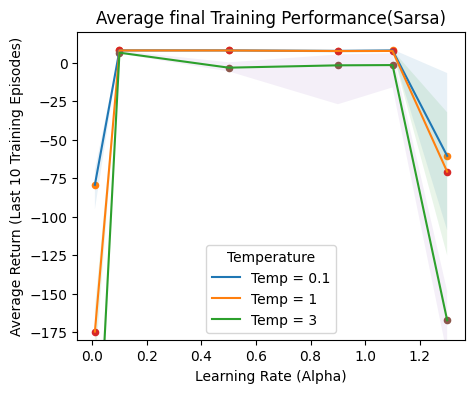

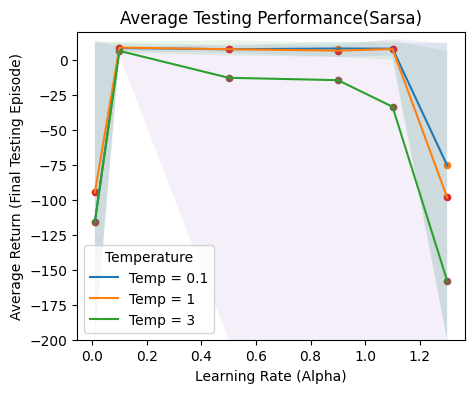

In [ ]:
# Calculate the average return over the last 10 training episodes for each parameter setting, averaged over all trials
training_last_10_avg_sa = np.mean(training_results_sa[:, :, :, -10:], axis=3)

# Calculate the average and the min/max for uncertainty of training performance
training_avg_sa = np.mean(training_last_10_avg_sa, axis=2)  # Average over trials
training_min_sa = np.min(training_last_10_avg_sa, axis=2)  # Min over trials for uncertainty
training_max_sa = np.max(training_last_10_avg_sa, axis=2)  # Max over trials for uncertainty

# For testing performance, we're interested in the final testing episode
testing_avg_sa = np.mean(testing_results_sa[:, :, :, -1], axis=2)  # Average over trials
testing_min = np.min(testing_results_sa[:, :, :, -1], axis=2)  # Min over trials for uncertainty
testing_max = np.max(testing_results_sa[:, :, :, -1], axis=2)  # Max over trials for uncertainty

# Plot Training Performance with points
plt.figure(figsize=(5,4))
for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, training_avg_sa[:, i], label=f'Temp = {temp}')
    plt.fill_between(alpha_values, training_min_sa[:, i], training_max_sa[:, i], alpha=0.1)
    plt.scatter(alpha_values, training_avg_sa[:, i], s=20)  # Plot each point
plt.title('Average final Training Performance(Sarsa)')
plt.xlabel('Learning Rate (Alpha)')
plt.ylabel('Average Return (Last 10 Training Episodes)')
plt.legend(title='Temperature')
plt.ylim(-180, 20)
plt.show()

# Plot Testing Performance with points
plt.figure(figsize=(5,4))
for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, testing_avg_sa[:, i], label=f'Temp = {temp}')
    plt.fill_between(alpha_values, testing_min[:, i], testing_max[:, i], alpha=0.1)
    plt.scatter(alpha_values, testing_avg_sa[:, i], s=20)  # Plot each point
plt.title('Average Testing Performance(Sarsa)')
plt.xlabel('Learning Rate (Alpha)')
plt.ylabel('Average Return (Final Testing Episode)')
plt.legend(title='Temperature')
plt.ylim(-200, 20)
plt.show()

## Expected Sarsa performance

In [ ]:
# Parameters
alpha_values = [0.01,0.1,0.5,0.9,1.1,1.3]
temp_values = [0.1,1,3]
trials = 10
segments = 500
episodes_per_segment = 10
testing_episode = 1

# Initialize the environment
env = gym.make('Taxi-v3')

# Data storage
training_results_es = np.zeros((len(alpha_values), len(temp_values), trials, segments))
testing_results_es = np.zeros_like(training_results_es)

for i, alpha in enumerate(alpha_values):
    for j, temp in enumerate(temp_values):
        for trial in tqdm(range(trials), desc=f'Alpha: {alpha}, Temp: {temp}'):
            agent = ExpectedSarsa(env, alpha, gamma=0.99, temp=temp)
            for segment in range(segments):
                total_reward = 0
                for episode in range(episodes_per_segment):
                    state = env.reset()
                    action = agent.select_action(state)
                    done = False
                    while not done:
                        next_state, reward, done, _ = env.step(action)
                        next_action = agent.select_action(next_state)  # For action selection consistency
                        agent.update(state, action, reward, next_state, done)
                        state = next_state
                        action = next_action
                        total_reward += reward
                training_results_es[i, j, trial, segment] = total_reward / episodes_per_segment

                # Testing episode
                state = env.reset()
                done = False
                total_reward = 0
                while not done:
                    action = agent.select_action(state, greedy=True)
                    state, reward, done, _ = env.step(action)
                    total_reward += reward
                testing_results_es[i, j, trial, segment] = total_reward

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Alpha: 0.01, Temp: 0.1:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Alpha: 1.3, Temp: 3: 100%|██████████| 10/10 [07:51<00:00, 47.12s/it]


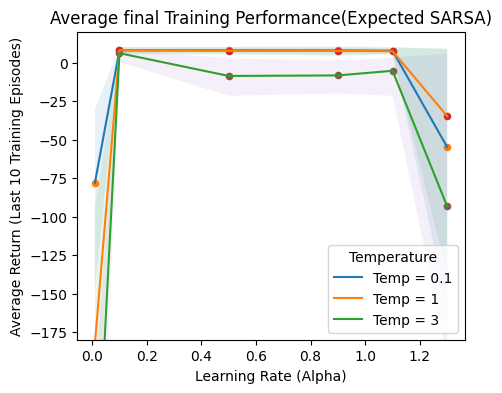

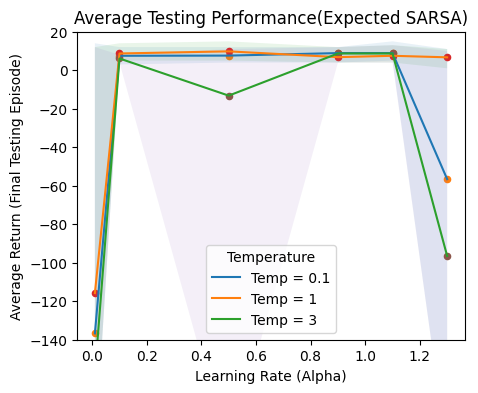

In [ ]:
# Processing results for plotting
training_avg_es = np.mean(training_results_es[..., -10:], axis=(2, 3))
testing_avg_es = np.mean(testing_results_es[..., -1], axis=2)
training_min_es = np.min(training_results_es[..., -10:], axis=(2, 3))
training_max_es = np.max(training_results_es[..., -10:], axis=(2, 3))
testing_min_es = np.min(testing_results_es[..., -1], axis=2)
testing_max_es = np.max(testing_results_es[..., -1], axis=2)

# Plotting
plt.figure(figsize=(5,4))
for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, training_avg_es[:, i], label=f'Temp = {temp}')
    plt.fill_between(alpha_values, training_min_es[:, i], training_max_es[:, i], alpha=0.1)
    plt.scatter(alpha_values, training_avg_es[:, i], s=20)
plt.title('Average final Training Performance(Expected SARSA)')
plt.xlabel('Learning Rate (Alpha)')
plt.ylabel('Average Return (Last 10 Training Episodes)')
plt.legend(title='Temperature')
plt.ylim(-180, 20)
plt.show()

plt.figure(figsize=(5,4))
for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, testing_avg_es[:, i], label=f'Temp = {temp}')
    plt.fill_between(alpha_values, testing_min_es[:, i], testing_max_es[:, i], alpha=0.1)
    plt.scatter(alpha_values, testing_avg_es[:, i], s=20)
plt.title('Average Testing Performance(Expected SARSA)')
plt.xlabel('Learning Rate (Alpha)')
plt.ylabel('Average Return (Final Testing Episode)')
plt.legend(title='Temperature')
plt.ylim(-140, 20)
plt.show()

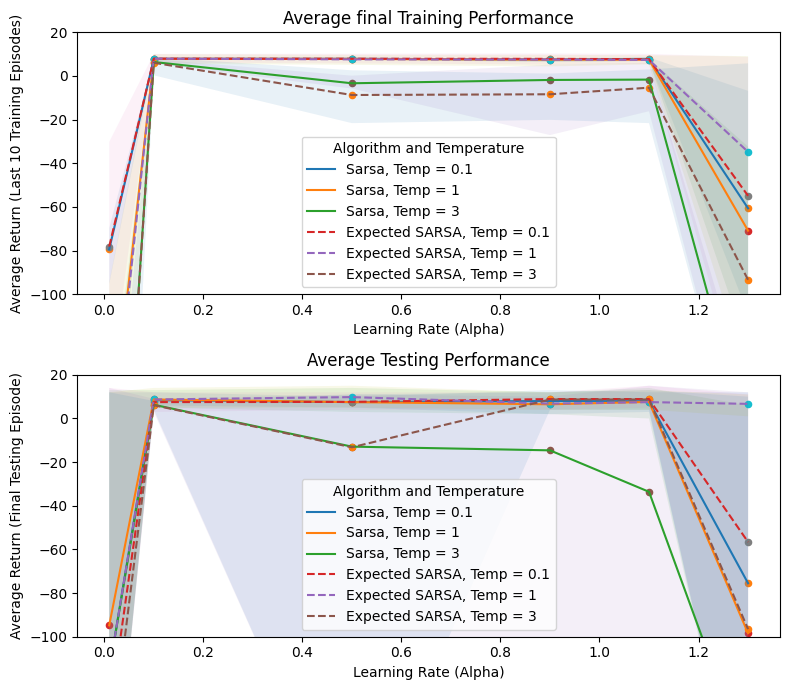

In [ ]:
# Plot Training Performance for both algorithms
plt.figure(figsize=(8, 7))

# Training Performance
plt.subplot(2, 1, 1)
for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, training_avg_sa[:, i], label=f'Sarsa, Temp = {temp}')
    plt.fill_between(alpha_values, training_min_sa[:, i], training_max_sa[:, i], alpha=0.1)
    plt.scatter(alpha_values, training_avg_sa[:, i], s=20)

for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, training_avg_es[:, i], label=f'Expected SARSA, Temp = {temp}', linestyle='--')
    plt.fill_between(alpha_values, training_min_es[:, i], training_max_es[:, i], alpha=0.1)
    plt.scatter(alpha_values, training_avg_es[:, i], s=20)

plt.title('Average final Training Performance')
plt.xlabel('Learning Rate (Alpha)')
plt.ylabel('Average Return (Last 10 Training Episodes)')
plt.legend(title='Algorithm and Temperature')
plt.ylim(-100, 20)

# Testing Performance
plt.subplot(2, 1, 2)
for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, testing_avg_sa[:, i], label=f'Sarsa, Temp = {temp}')
    plt.fill_between(alpha_values, testing_min[:, i], testing_max[:, i], alpha=0.1)
    plt.scatter(alpha_values, testing_avg_sa[:, i], s=20)

for i, temp in enumerate(temp_values):
    plt.plot(alpha_values, testing_avg_es[:, i], label=f'Expected SARSA, Temp = {temp}', linestyle='--')
    plt.fill_between(alpha_values, testing_min_es[:, i], testing_max_es[:, i], alpha=0.1)
    plt.scatter(alpha_values, testing_avg_es[:, i], s=20)

plt.title('Average Testing Performance')
plt.xlabel('Learning Rate (Alpha)')
plt.ylabel('Average Return (Final Testing Episode)')
plt.legend(title='Algorithm and Temperature')
plt.ylim(-100, 20)

plt.tight_layout()
plt.show()


## Learning curve

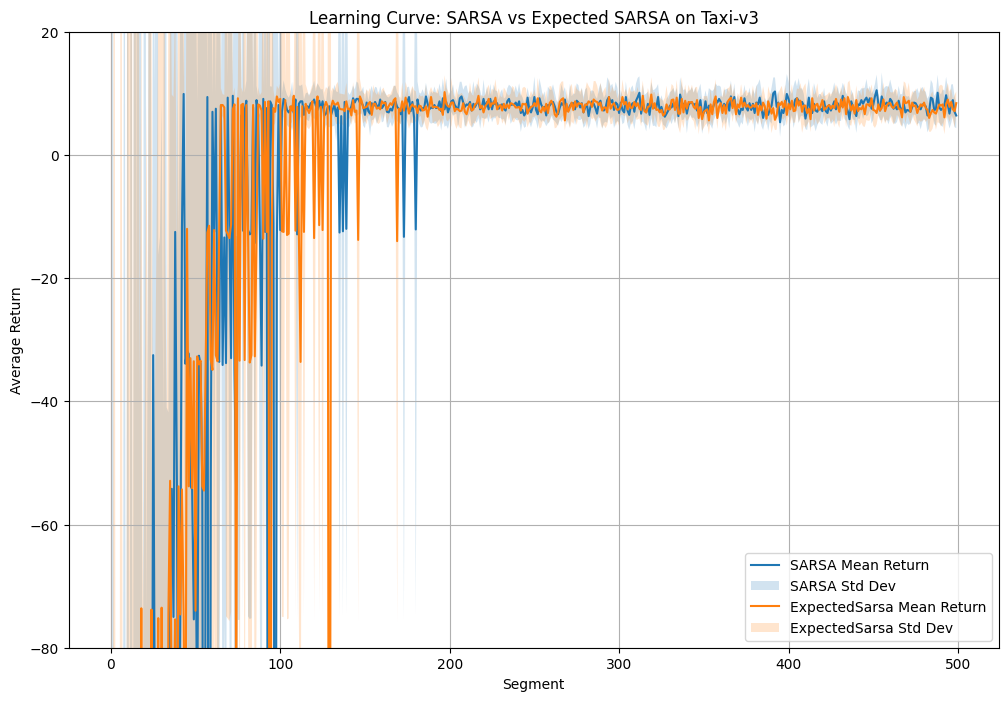

In [ ]:
def run_experiment(agent_class, env, alpha, temp, segments, training_episodes, trials):
    all_returns = np.zeros((trials, segments))  # To store returns for all trials and segments

    for trial in range(trials):
        agent = agent_class(env, alpha, gamma=0.99, temp=temp)  # Initialize agent
        for segment in range(segments):
            for _ in range(training_episodes):
                state = env.reset()
                action = agent.select_action(state)
                done = False
                while not done:
                    next_state, reward, done, info = env.step(action)
                    if agent_class == ExpectedSarsa:
                        agent.update(state, action, reward, next_state, done)
                    else:  # SARSA
                        next_action = agent.select_action(next_state)
                        agent.update(state, action, reward, next_state, next_action, done)
                    action = agent.select_action(next_state) if done == False else agent.select_action(next_state, greedy=True)
                    state = next_state

            # Test episode
            total_reward = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.select_action(state, greedy=True)
                state, reward, done, info = env.step(action)
                total_reward += reward
            all_returns[trial, segment] = total_reward

    mean_returns = np.mean(all_returns, axis=0)
    std_returns = np.std(all_returns, axis=0)
    return mean_returns, std_returns

# Experiment setup
env = gym.make('Taxi-v3')
segments = 500
training_episodes = 10
trials = 10

# Hyperparameters for both algorithms
hyperparameters = {
    "SARSA": {"alpha": 0.5, "temp": 0.1},
    "ExpectedSarsa": {"alpha": 0.5, "temp": 0.1}
}

# Running experiments
results = {}
for name, params in hyperparameters.items():
    agent_class = SARSA if name == "Sarsa" else ExpectedSarsa
    mean_returns, std_returns = run_experiment(agent_class, env, params["alpha"], params["temp"], segments, training_episodes, trials)
    results[name] = (mean_returns, std_returns)

# Plotting the learning curves with standard deviation
plt.figure(figsize=(12, 8))
for name, (mean_returns, std_returns) in results.items():
    plt.plot(mean_returns, label=f'{name} Mean Return')
    plt.fill_between(range(segments), mean_returns-std_returns, mean_returns+std_returns, alpha=0.2)

plt.xlabel('Segment')
plt.ylabel('Average Return')
plt.title('Learning Curve: SARSA vs Expected SARSA on Taxi-v3')
plt.legend()
plt.grid(True)
plt.ylim(-80, 20)
plt.show()

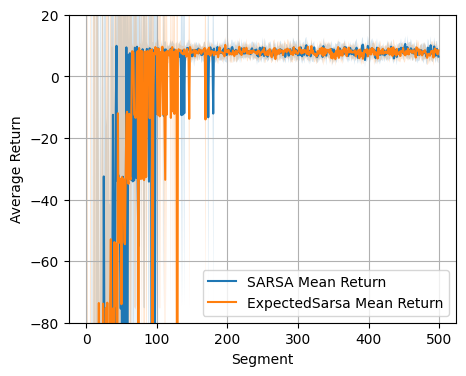

In [ ]:
# Plotting the learning curves with standard deviation
plt.figure(figsize=(5, 4))
for name, (mean_returns, std_returns) in results.items():
    plt.plot(mean_returns, label=f'{name} Mean Return')
    plt.fill_between(range(segments), mean_returns-std_returns, mean_returns+std_returns, alpha=0.2,)

plt.xlabel('Segment')
plt.ylabel('Average Return')
# plt.title('Learning Curve: SARSA vs Expected SARSA on Taxi-v3')
plt.legend()
plt.grid(True)
plt.ylim(-80, 20)
plt.show()

## Hybrid Sarsa performance

In [ ]:
def run_trial(env, alpha, beta, temp=1, total_segments=500, episodes_per_segment=10):
    agent = Hybrid_Sarsa_Q(env, alpha, gamma=0.99, temp=temp, beta=beta)
    training_returns = []  # Store the returns for each training episode
    testing_returns = []  # Store the returns for each testing episode

    for segment in range(total_segments):
        # Training episodes
        for episode in range(episodes_per_segment):
            total_reward = 0
            done = False
            state = env.reset()
            action = agent.select_action(state)
            while not done:
                next_state, reward, done, _ = env.step(action)
                next_action = agent.select_action(next_state)
                agent.update(state, action, reward, next_state, next_action, done)
                state, action = next_state, next_action
                total_reward += reward
            training_returns.append(total_reward)

        # Testing episode
        if segment == total_segments - 1:  # Only record the last testing episode
            total_reward = 0
            done = False
            state = env.reset()
            while not done:
                action = agent.select_action(state, greedy=True)
                state, reward, done, _ = env.step(action)
                total_reward += reward
            testing_returns.append(total_reward)

    # Calculate the average, min, and max of the last 10 training episodes
    training_average = np.mean(training_returns[-10:])
    training_min = np.min(training_returns[-10:])
    training_max = np.max(training_returns[-10:])
    testing_average = np.mean(testing_returns)  # Should be only one value here

    return training_average, training_min, training_max, testing_average

env = gym.make('Taxi-v3')
alpha_values = [0.1,0.3,0.5,0.7,0.9]
beta_values = [0.01, 0.5, 0.99]
num_trials = 10

# Initialize storage for results
results = {
    'training': {alpha: {beta: [] for beta in beta_values} for alpha in alpha_values},
    'testing': {alpha: {beta: [] for beta in beta_values} for alpha in alpha_values}
}

# Run experiments
for alpha in alpha_values:
    for beta in beta_values:
        training_averages = []
        testing_averages = []
        training_mins = []
        training_maxs = []
        for trial in tqdm(range(num_trials), desc=f'Alpha: {alpha}, Beta: {beta}'):
            train_avg, train_min, train_max, test_avg = run_trial(env, alpha, beta)
            training_averages.append(train_avg)
            training_mins.append(train_min)
            training_maxs.append(train_max)
            testing_averages.append(test_avg)
        # Store the average, min, and max for training, and the average for testing
        results['training'][alpha][beta] = (np.mean(training_averages), np.min(training_mins), np.max(training_maxs))
        results['testing'][alpha][beta] = np.mean(testing_averages)


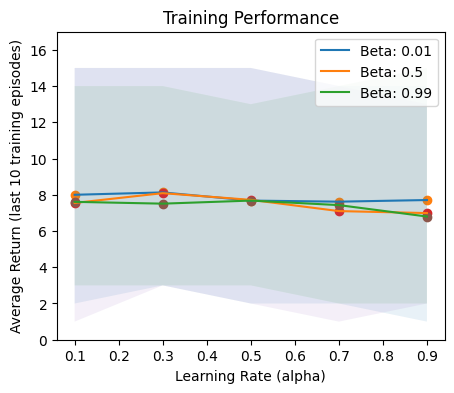

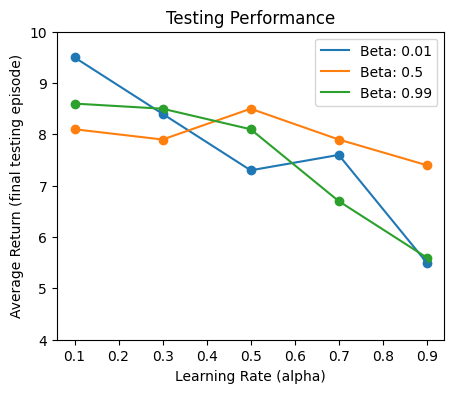

In [ ]:
alpha_values = [0.1,0.3,0.5,0.7,0.9]
beta_values = [0.01, 0.5, 0.99]

# Plotting Training Performances with Variability
plt.figure(figsize=(5, 4))

for beta in beta_values:
    # Extracting training means, mins, and maxs for plotting
    training_means = [results['training'][alpha][beta][0] for alpha in alpha_values]
    training_mins = [results['training'][alpha][beta][1] for alpha in alpha_values]
    training_maxs = [results['training'][alpha][beta][2] for alpha in alpha_values]

    # Plot the mean training performance
    plt.plot(alpha_values, training_means, label=f'Beta: {beta}')
    # Add shading for the variability range (min to max)
    plt.fill_between(alpha_values, training_mins, training_maxs, alpha=0.1)
    # Plot specific data points for the means
    plt.scatter(alpha_values, training_means, marker='o')

plt.title('Training Performance')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Average Return (last 10 training episodes)')
plt.legend()
plt.ylim(0, 17)
plt.show()

# Plotting Testing Performances with Data Points
plt.figure(figsize=(5, 4))

for beta in beta_values:
    # Extracting testing means for plotting
    testing_means = [results['testing'][alpha][beta] for alpha in alpha_values]

    # Plot the testing performance
    plt.plot(alpha_values, testing_means, label=f'Beta: {beta}')
    # Plot specific data points for the means
    plt.scatter(alpha_values, testing_means, marker='o')

plt.title('Testing Performance')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Average Return (final testing episode)')
plt.legend()
plt.ylim(4, 10)
plt.show()
